In [1]:
import sqc
import numpy as np
from exercises import CRz,qft,C2NOT
import matplotlib.pyplot as plt

In [2]:
# Only implement improved trotter
def CT(c,xbits,Ntrot,dt,op,params):
    op=CT0(c,xbits,dt/Ntrot/2.,op,params)
    for i in range(Ntrot-1):
        op=CT1(c,xbits,dt/Ntrot,op,params)
        op=CT0(c,xbits,dt/Ntrot,op,params)
    op=CT1(c,xbits,dt/Ntrot,op,params)
    op=CT0(c,xbits,dt/Ntrot/2.,op,params)
    return op

# Helper
def period(x,L):
    if x >= L/2:
        return x - L
    return x

def w(j,N):
    assert(j<N and j>=0)
    if j == N-1:
        return -2**j
    return 2**j

# exp(I a x)
def CexpIaX(c,a,xbits,op):
    N=len(xbits)
    for j in range(len(xbits)):
        op=CRz(c,xbits[j],a*w(j,N),op)
    return op

# exp(I a p)
def CexpIaP(c,a,xbits,op):
    N=len(xbits)
    op=qft(op,mask=xbits,inverse=False)
    op=CexpIaX(c,a*2.*np.pi / 2**N,xbits,op)
    op=qft(op,mask=xbits,inverse=True)
    return op

# exp(I a x^2)
def CexpIaX2(c,a,xbits,op):
    N=len(xbits)
    l=a/12.*(2.+4.**N)-a/2.
    op=CRz(c,xbits[0],l,CRz(c,xbits[0],l,op.X(xbits[0])).X(xbits[0]))
    for j in range(len(xbits)):
        op=CRz(c,xbits[j],-a*w(j,N),op)
        for i in range(len(xbits)):
            if i != j:
                t=a/4.*w(j,N)*w(i,N)
                ga=xbits[i]
                gb=xbits[j]
                op=op.CNOT(gb,ga)
                op=op.X(ga)
                op=CRz(c,ga,t,op)
                op=op.X(ga)
                op=CRz(c,ga,-t,op)
                op=op.CNOT(gb,ga)
    return op

# exp(I a p^2)
def CexpIaP2(c,a,xbits,op):
    N=len(xbits)
    op=qft(op,mask=xbits,inverse=False)
    op=CexpIaX2(c,a*(2.*np.pi / 2**N)**2.,xbits,op)
    op=qft(op,mask=xbits,inverse=True)
    return op

# Simple potential
def C2Rz(c0,c1,t,phi,o):
    o=CRz(c0,t,phi/2.,o)
    o=C2NOT(c0,c1,t,o)
    o=CRz(c0,t,-phi/2.,o)
    o=CRz(c0,c1,phi/2.,o)
    o=C2NOT(c0,c1,t,o)
    return o

In [3]:
# Kinetic term
def CT0(c,xbits,dt,op,params):
    mass=params[0]
    return CexpIaP2(c,dt/2.0/mass,xbits,op)

# Potential term
def CT1(c,xbits,dt,op,params):
    V0=params[1]
    c0=xbits[-1]
    c1=xbits[-2]
    return C2Rz(c,c0,c1,V0*dt,op.X(c0)).X(c0)

In [4]:
nabits=1
nxbits=5
nbits=nabits+nxbits
s0=sqc.state(nbits,basis=["|%d>|%d>" % (x//2**nxbits,period(x%2**nxbits,2**nxbits))
                          for x in range(2**nbits)])
s1=CT1(nxbits,range(nxbits),1.,sqc.operator(nbits).H(0).H(1).H(2).H(3).H(4).X(nxbits),[1,1])*s0
print(s1)

   0.176777              * |1>|0>
 + 0.176777              * |1>|1>
 + 0.176777              * |1>|2>
 + 0.176777              * |1>|3>
 + 0.176777              * |1>|4>
 + 0.176777              * |1>|5>
 + 0.176777              * |1>|6>
 + 0.176777              * |1>|7>
 + (0.0955129+0.148752j) * |1>|8>
 + (0.0955129+0.148752j) * |1>|9>
 + (0.0955129+0.148752j) * |1>|10>
 + (0.0955129+0.148752j) * |1>|11>
 + (0.0955129+0.148752j) * |1>|12>
 + (0.0955129+0.148752j) * |1>|13>
 + (0.0955129+0.148752j) * |1>|14>
 + (0.0955129+0.148752j) * |1>|15>
 + 0.176777              * |1>|-16>
 + 0.176777              * |1>|-15>
 + 0.176777              * |1>|-14>
 + 0.176777              * |1>|-13>
 + 0.176777              * |1>|-12>
 + 0.176777              * |1>|-11>
 + 0.176777              * |1>|-10>
 + 0.176777              * |1>|-9>
 + 0.176777              * |1>|-8>
 + 0.176777              * |1>|-7>
 + 0.176777              * |1>|-6>
 + 0.176777              * |1>|-5>
 + 0.176777            

In [5]:
def timeEvolutionPlot(dt,steps,s1,Ntrot,params):
    Tdt=CT(nxbits,range(nxbits),Ntrot,dt,sqc.operator(nbits),params)
    print(len(Tdt.m))
    sn=s1
    for tstep in range(steps):
        res=sqc.sample(sn, n=100, mask=range(nxbits))
        sn=Tdt*sn
    
        xvals=[ period(x,2**nxbits) for x in res.keys() ]
        yvals=res.values()

        plt.xlabel('x')
        plt.xlim(-2**nxbits/2,2**nxbits/2)
        plt.ylabel('count')
        plt.title('t=%g' % (tstep*dt))
        plt.bar(xvals,yvals,width=0.75)
        plt.show()
        
def createSource(xbits,p,op):
    n=len(xbits)
    for i in range(n):
        op=op.H(xbits[i]).Rz(xbits[i],-p*2**i)
    return op


nabits=1
nxbits=8
nbits=nabits+nxbits
s0=sqc.state(nbits,basis=["|%d>|%d>" % (x//2**nxbits,period(x%2**nxbits,2**nxbits))
                          for x in range(2**nbits)])

s1=createSource(range(4),2*np.pi/2**nxbits*64,sqc.operator(nbits).X(nxbits))*s0
print(s1)

   0.25    * |1>|0>
 + -0.25j  * |1>|1>
 + (-0.25) * |1>|2>
 + 0.25j   * |1>|3>
 + 0.25    * |1>|4>
 + -0.25j  * |1>|5>
 + (-0.25) * |1>|6>
 + 0.25j   * |1>|7>
 + 0.25    * |1>|8>
 + -0.25j  * |1>|9>
 + (-0.25) * |1>|10>
 + 0.25j   * |1>|11>
 + 0.25    * |1>|12>
 + -0.25j  * |1>|13>
 + (-0.25) * |1>|14>
 + 0.25j   * |1>|15>


14066


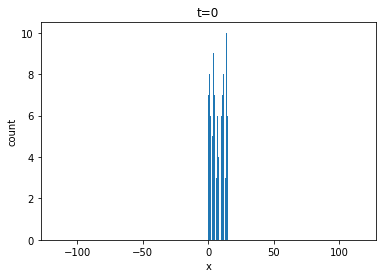

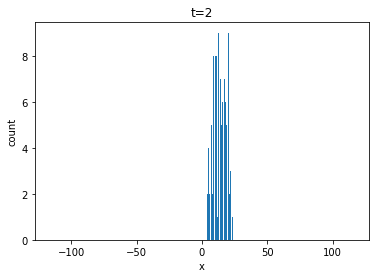

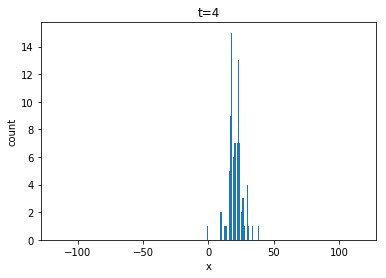

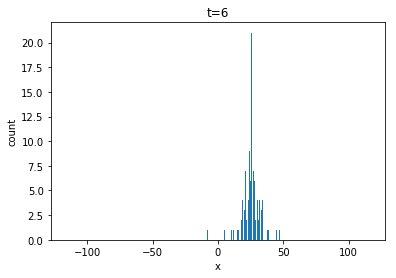

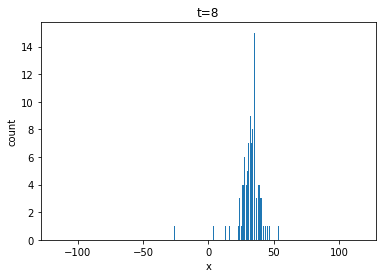

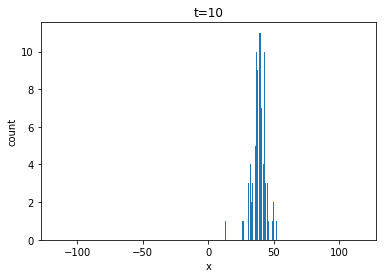

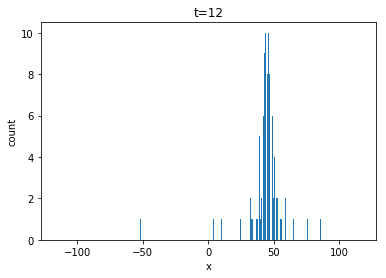

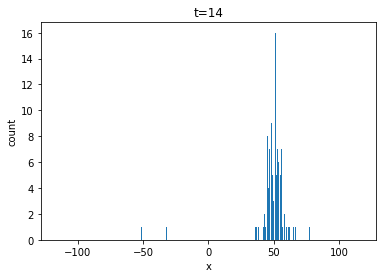

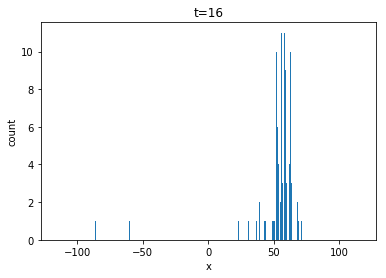

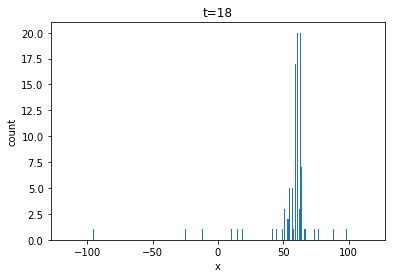

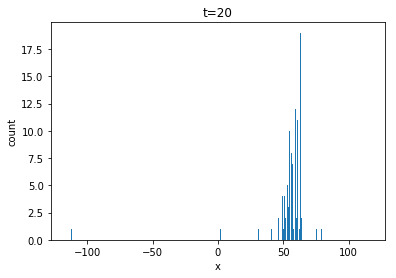

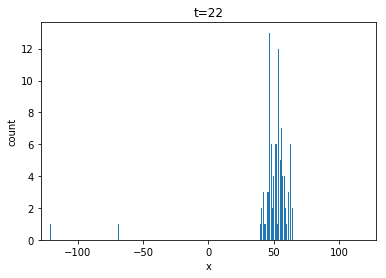

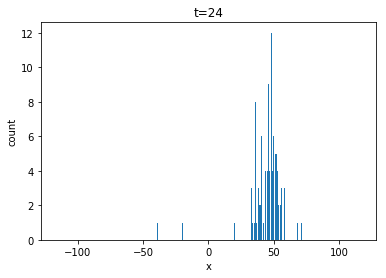

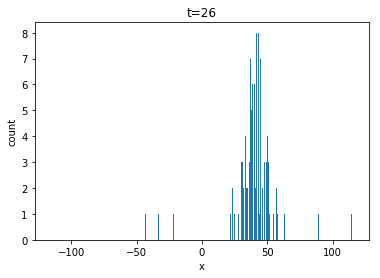

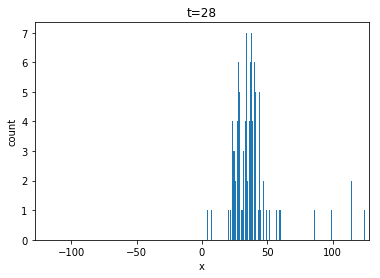

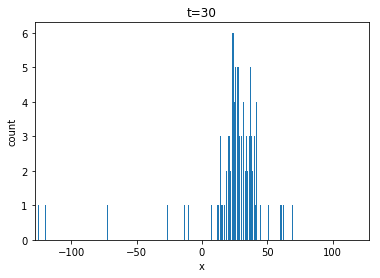

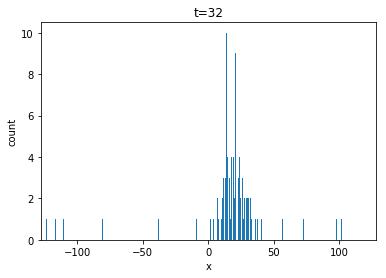

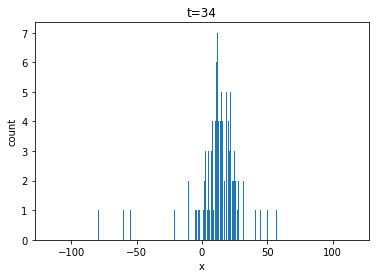

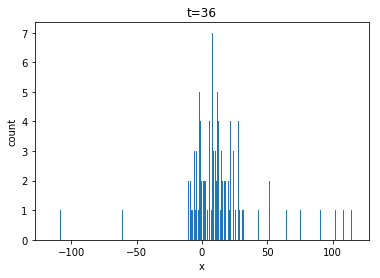

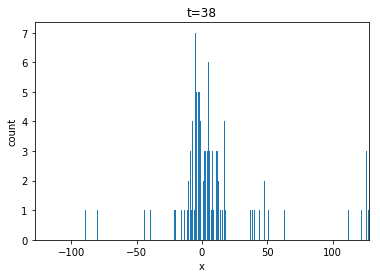

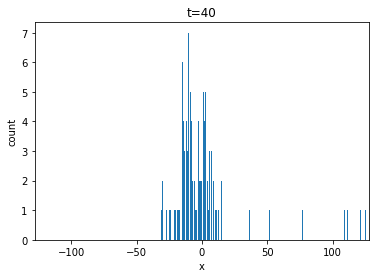

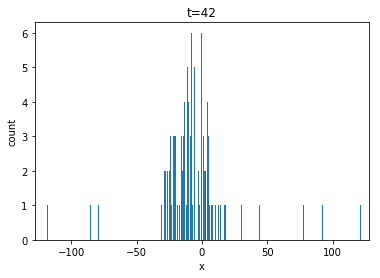

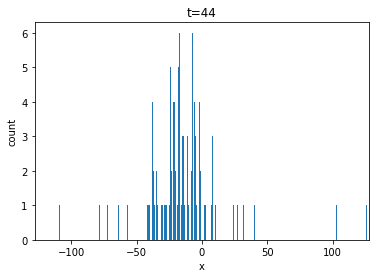

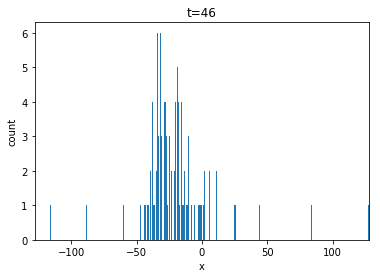

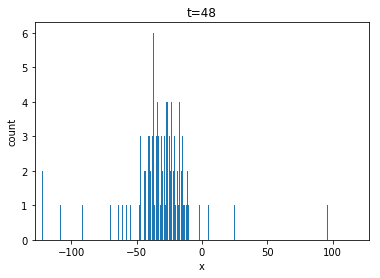

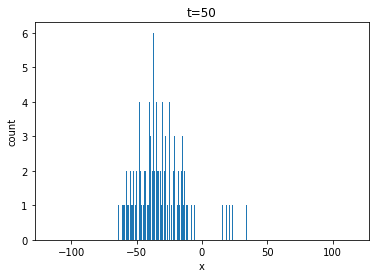

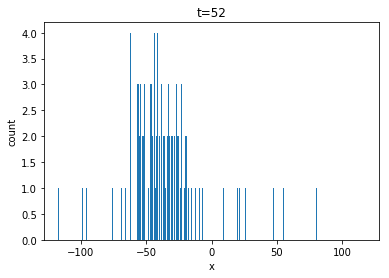

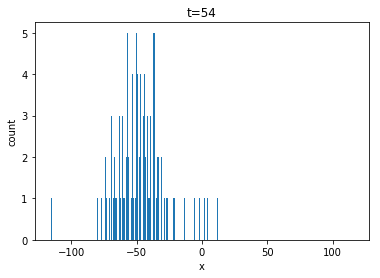

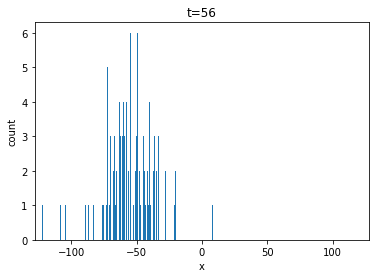

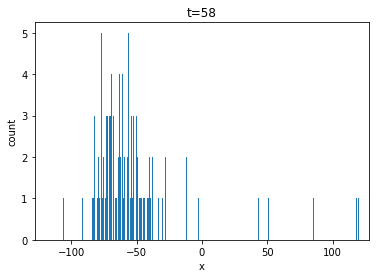

In [6]:
timeEvolutionPlot(2,30,s1,10,[0.5,3.5]) # Hard wall

14066


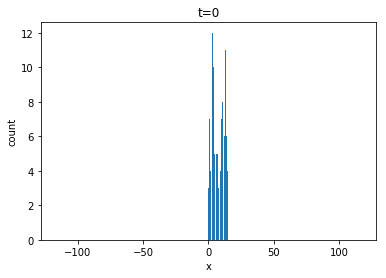

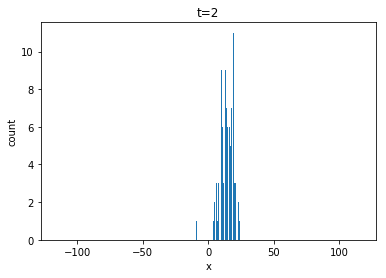

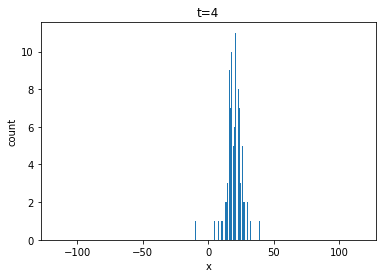

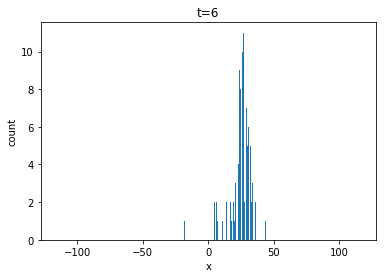

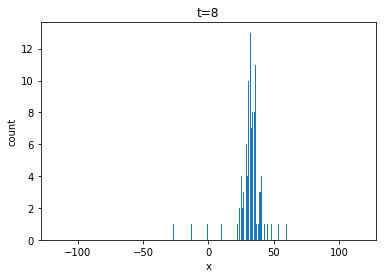

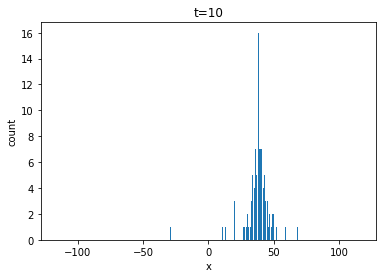

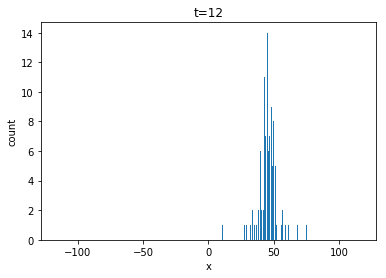

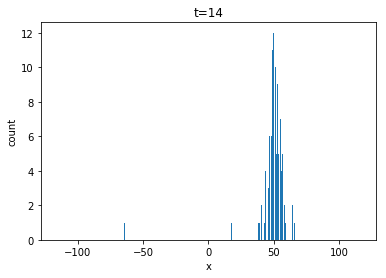

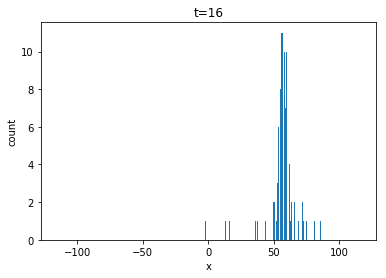

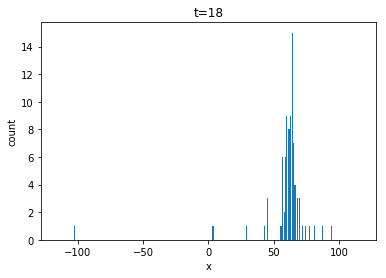

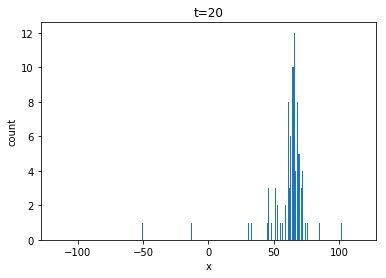

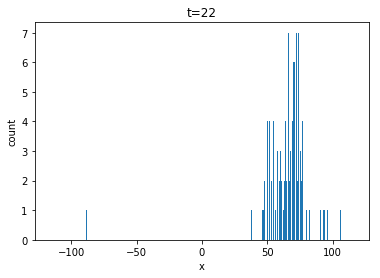

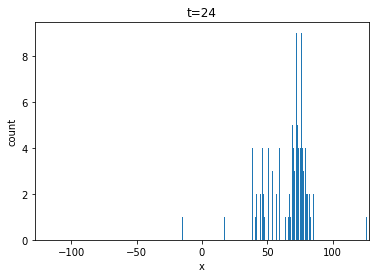

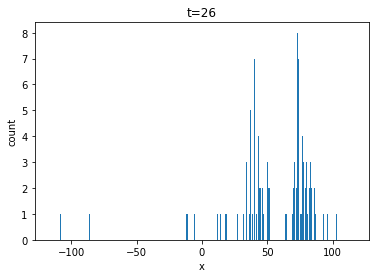

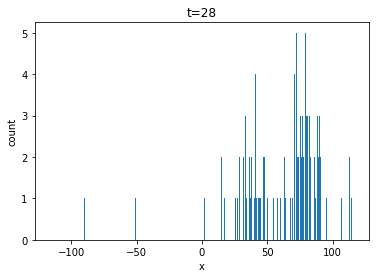

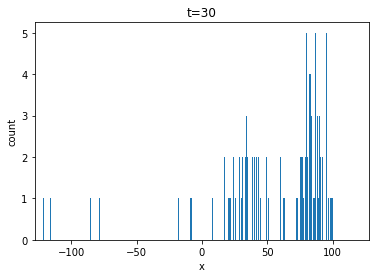

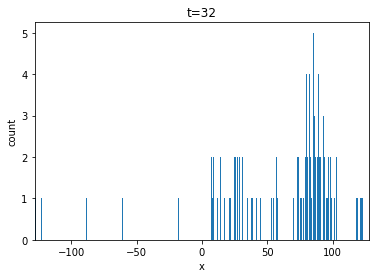

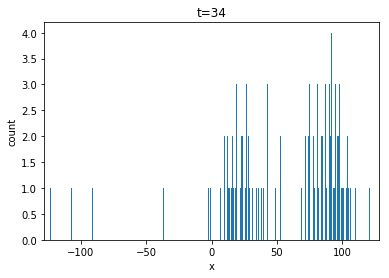

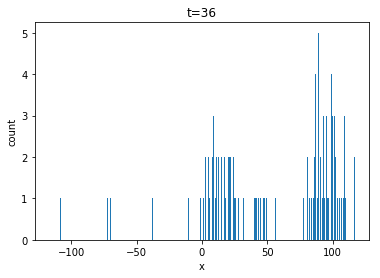

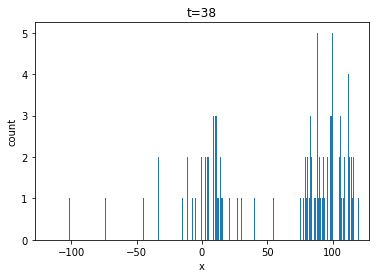

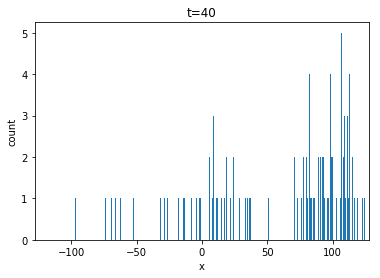

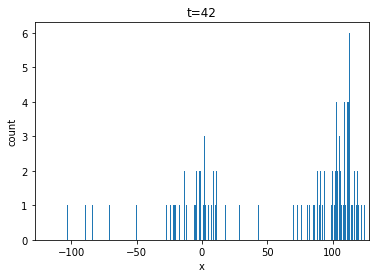

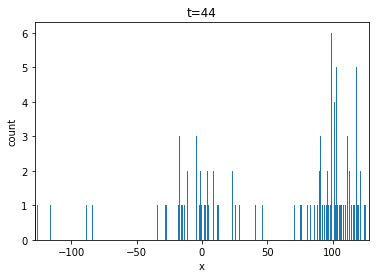

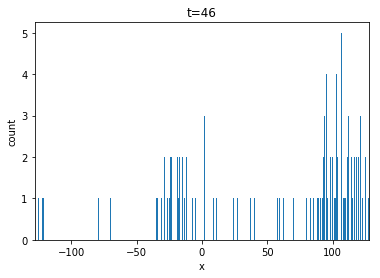

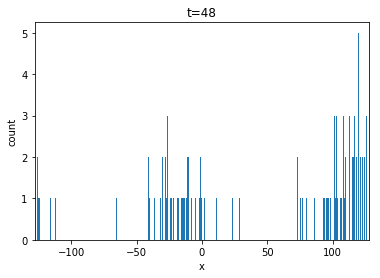

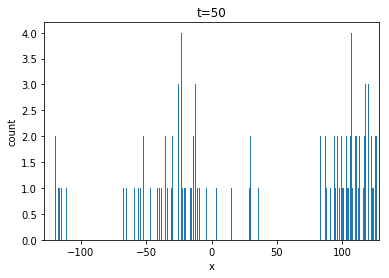

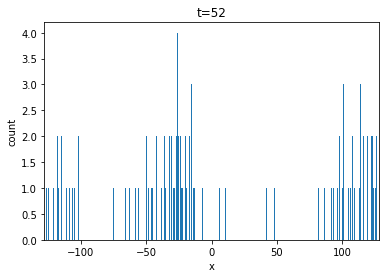

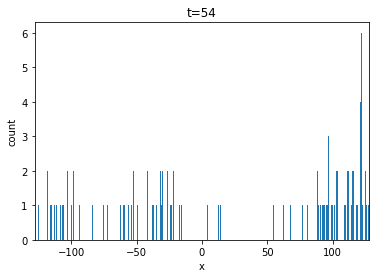

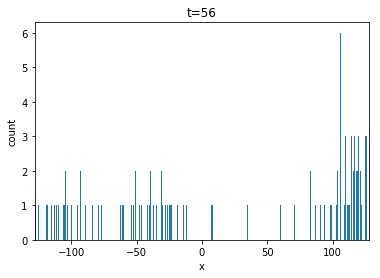

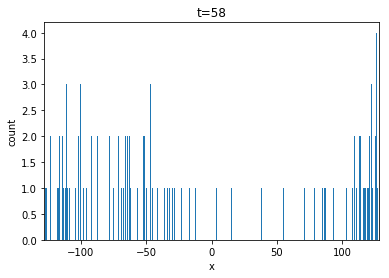

In [7]:
timeEvolutionPlot(2,30,s1,10,[0.5,2.0])

20521


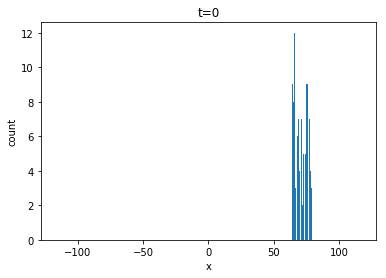

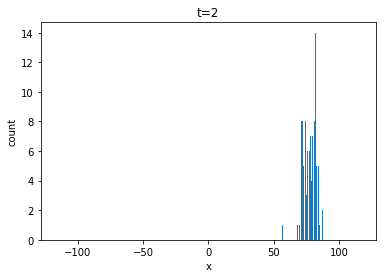

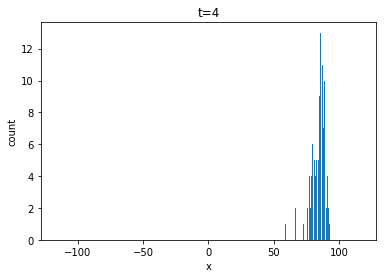

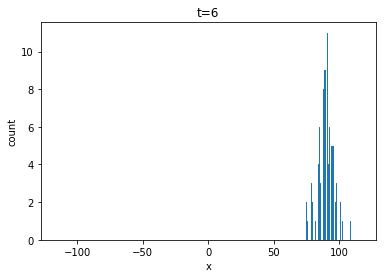

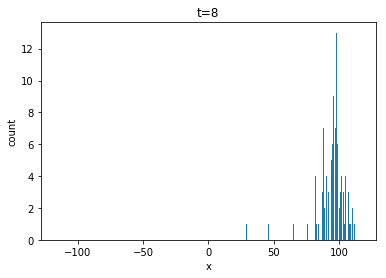

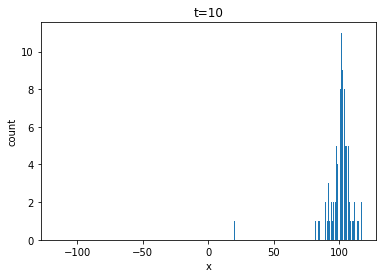

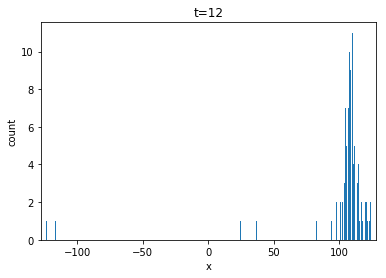

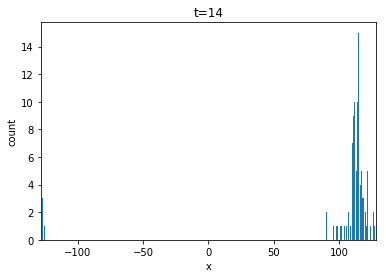

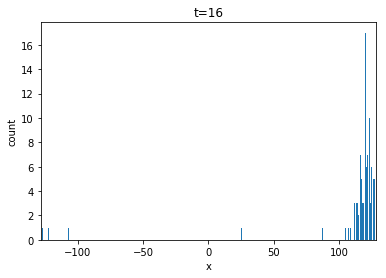

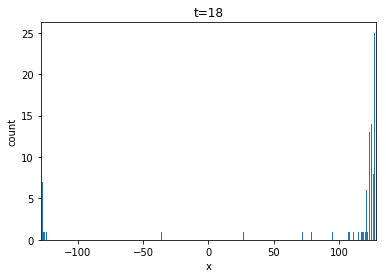

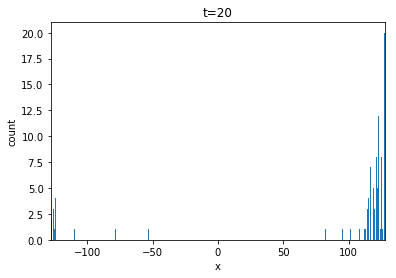

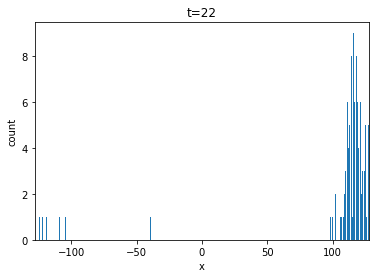

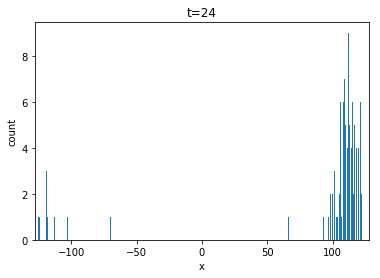

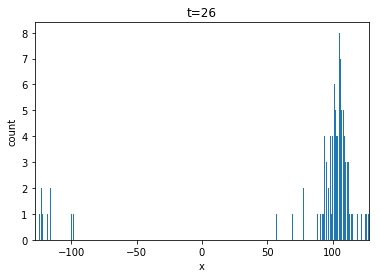

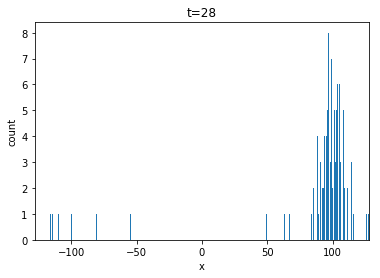

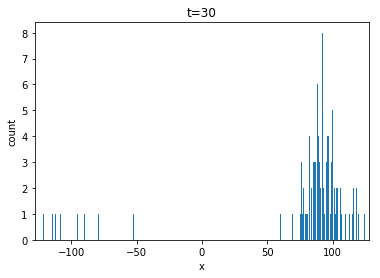

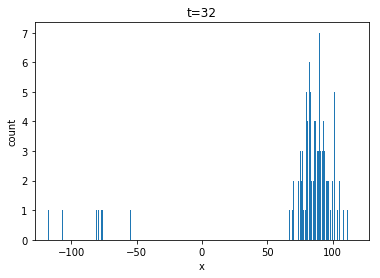

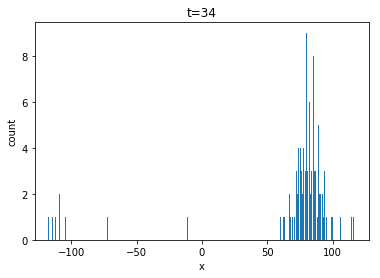

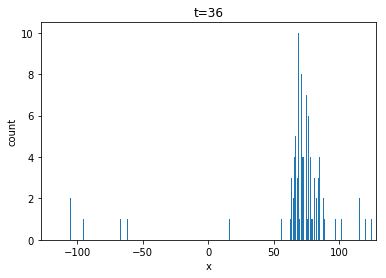

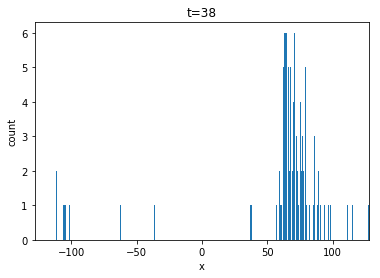

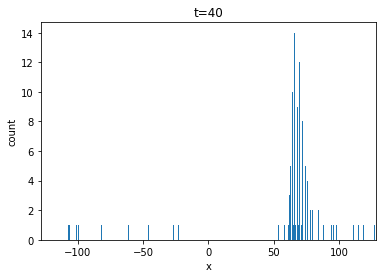

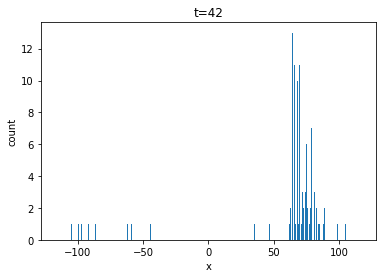

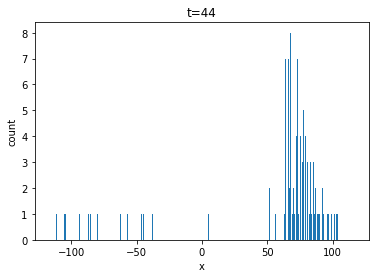

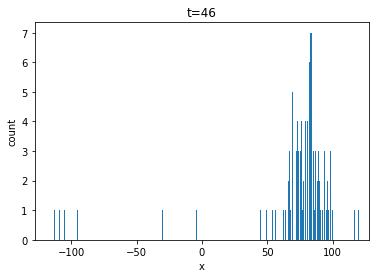

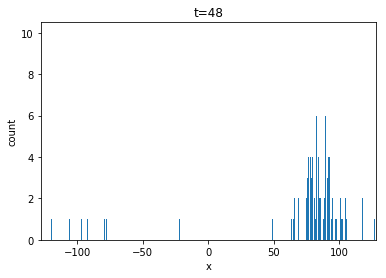

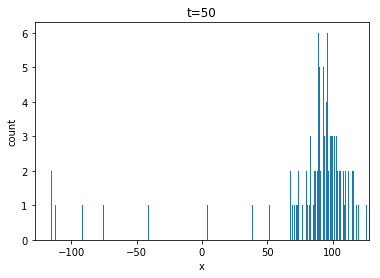

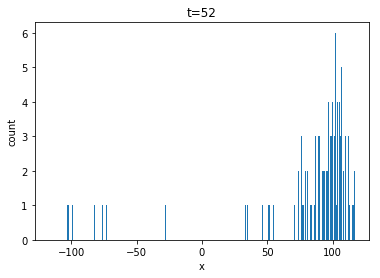

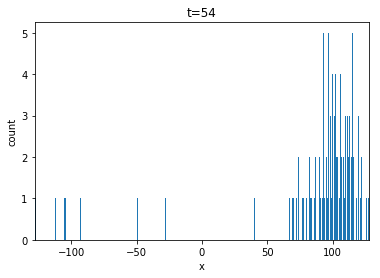

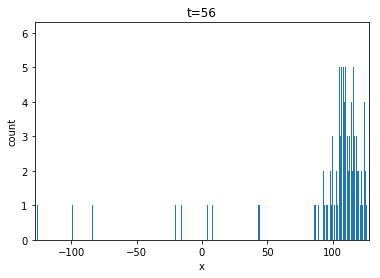

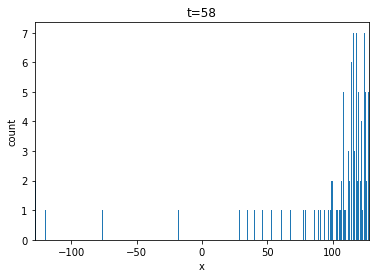

In [8]:
timeEvolutionPlot(2,30,sqc.operator(nbits).X(6)*s1,15,[0.5,-3.0])

In [9]:
# Next: harmonic oscillator, first propagation, then eigenspectrum
def CT1(c,xbits,dt,op,params):
    mass=params[0]
    omega=params[1]
    return CexpIaX2(c,dt*mass/2.*omega**2.,xbits,op)

21076


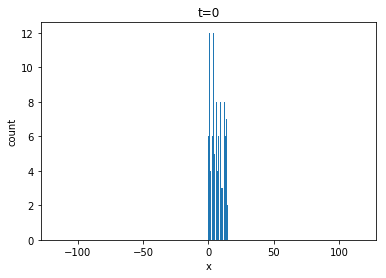

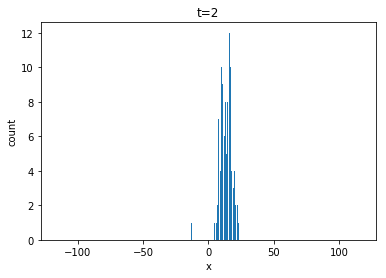

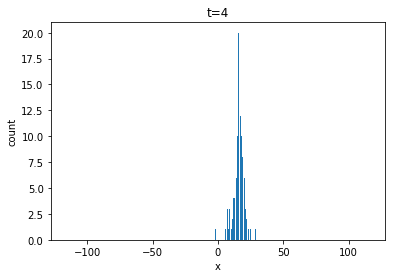

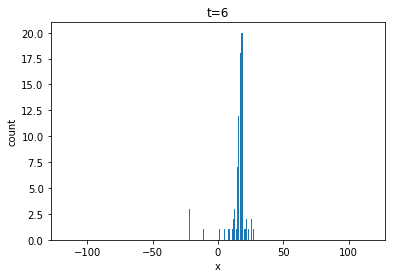

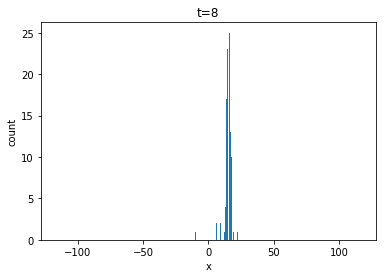

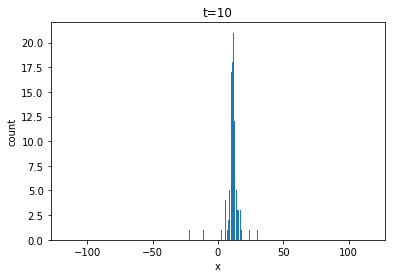

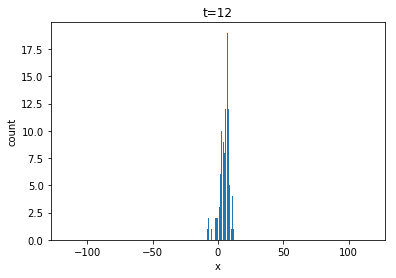

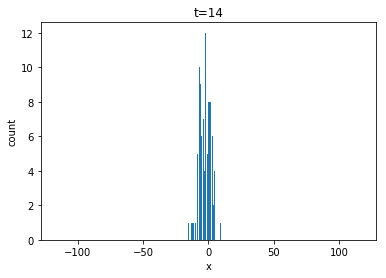

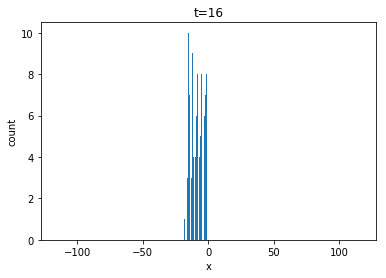

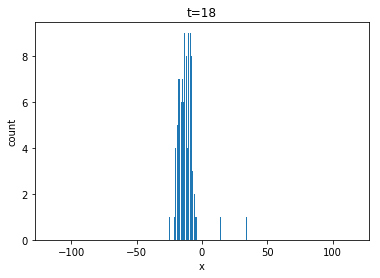

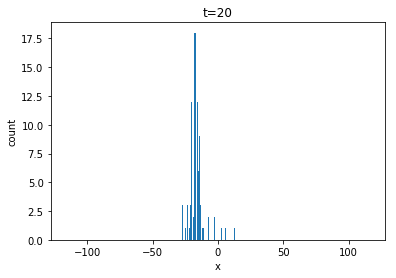

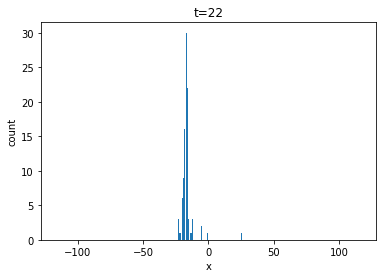

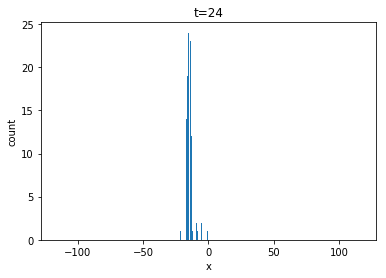

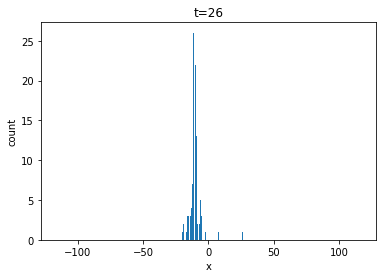

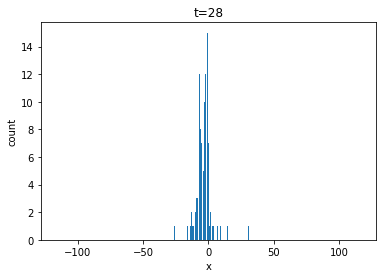

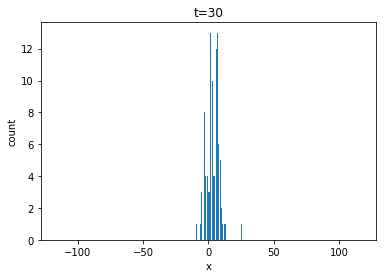

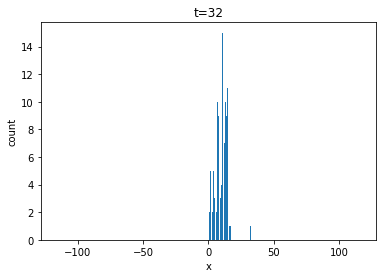

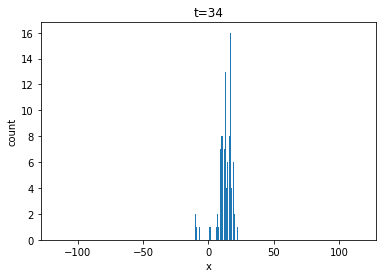

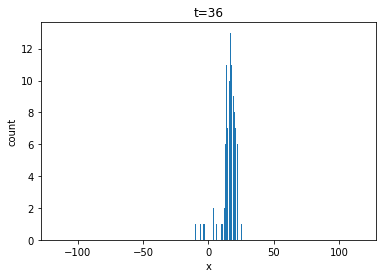

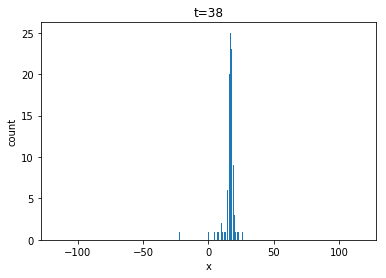

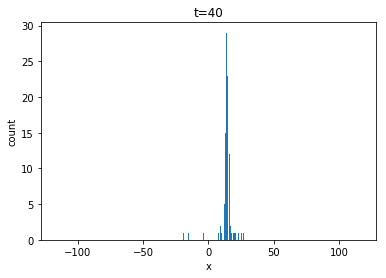

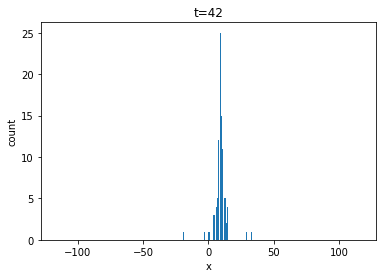

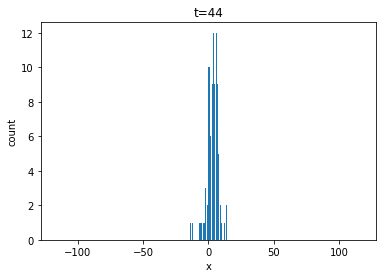

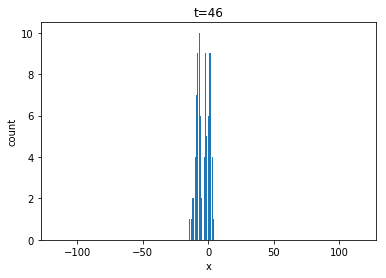

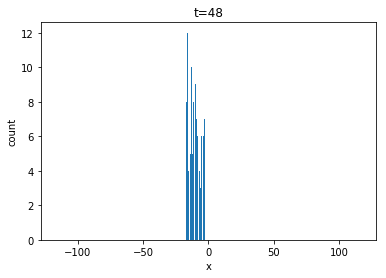

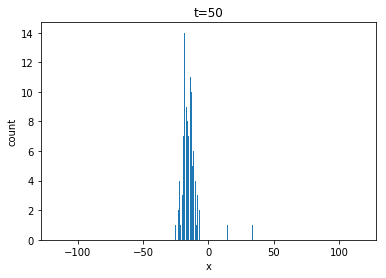

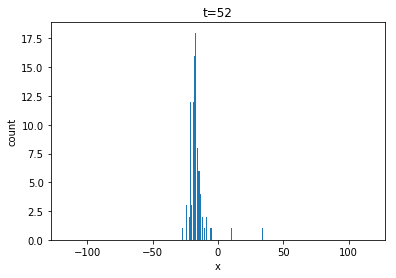

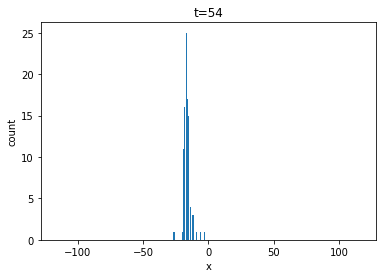

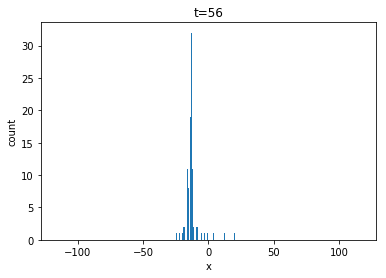

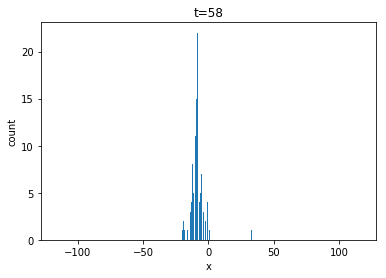

In [10]:
timeEvolutionPlot(2,30,s1,10,[0.5,0.2])

In [31]:
def phaseEstimate(op,xbits,cuj):
    N=len(xbits)
    for i in reversed(range(N)):
        op=op.H(xbits[i])
        op=cuj(xbits[i],2**i,op)
    op=qft(op,mask=xbits,inverse=True)
    return op

def periodPi(x):
    if x > np.pi:
        return x - 2*np.pi
    return x

def measure(Nxbits,Nsites,Nmeasure,cuj,prep=None,x0=-np.pi,x1=np.pi):
    Nbits=Nxbits+Nsites
    
    sbits=list(range(0,Nsites))
    
    xbits=list(range(Nsites,Nbits))
    
    st0=sqc.state(Nbits,basis=["|%g>|%d>" % 
        ( periodPi(2.*np.pi*(i//2**Nsites) / 2**Nxbits),
          period(i%2**Nsites,2**Nsites)) for i in range(2**Nbits)])
    if prep == None:
        st0=sqc.operator(Nbits)*st0
    else:
        st0=prep*st0
    print("Initial = 0\n",st0)

    st1=phaseEstimate(sqc.operator(Nbits),xbits,cuj)*st0

    if Nmeasure == 0:
        print("State after phaseEstimate\n",st1)
    else:
        res,resstates=sqc.sample(st1,Nmeasure,mask=xbits,save_states=True)
        
        plt.bar([ periodPi(2.*np.pi*x / 2**Nxbits) for x in res.keys() ],res.values(),width=5.0/2.0**Nxbits)
        plt.xlabel('eval*t')
        plt.xlim(x0,x1)
        plt.ylabel('count')
        plt.show()
        
        # show two most sampled states
        evs=list(reversed(sorted(list(res.values()))))[0:2]
        
        for e in evs:
            imax=list(res.values()).index(e)
            ev=resstates[list(res.keys())[imax]]
            print(ev)
        
            xres=sqc.sample(ev,Nmeasure,mask=sbits)
            xvals=[ period(x,2**Nsites) for x in xres.keys() ]
            yvals=xres.values()

            plt.xlabel('x')
            plt.xlim(-2**Nsites/2,2**Nsites/2)
            plt.ylabel('count')
            plt.bar(xvals,yvals,width=0.75)
            plt.show()

Initial = 0
    1 * |0>|0>


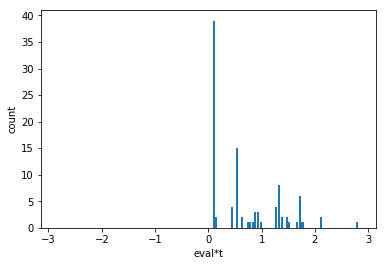

   (0.580297+0.260928j)        * |0.0981748>|0>
 + (0.445692+0.201067j)        * |0.0981748>|1>
 + (0.209764+0.0956707j)       * |0.0981748>|2>
 + (0.0659499+0.028643j)       * |0.0981748>|3>
 + (0.0127721+0.00401544j)     * |0.0981748>|4>
 + (0.00111533-0.00083307j)    * |0.0981748>|5>
 + (0.000482573+0.000365716j)  * |0.0981748>|6>
 + (-0.00047828-0.000774711j)  * |0.0981748>|7>
 + (0.000313689+0.000532989j)  * |0.0981748>|8>
 + (-0.000309463-0.000814855j) * |0.0981748>|9>
 + (0.000139324+0.000655526j)  * |0.0981748>|10>
 + (-2.51353e-05+0.00112768j)  * |0.0981748>|11>
 + (-0.000631305+0.000754024j) * |0.0981748>|12>
 + (-0.000477967-0.000432173j) * |0.0981748>|13>
 + (0.000312098+0.000470934j)  * |0.0981748>|14>
 + (-0.00134484-0.000815075j)  * |0.0981748>|15>
 + (0.00210068+0.0013285j)     * |0.0981748>|-16>
 + (-0.00134484-0.000815075j)  * |0.0981748>|-15>
 + (0.000312098+0.000470934j)  * |0.0981748>|-14>
 + (-0.000477967-0.000432173j) * |0.0981748>|-13>
 + (-0.000631305+0.0007540

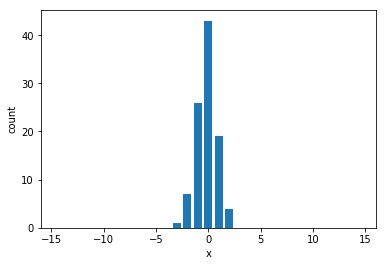

   (0.176695-0.394565j)       * |0.539961>|0>
 + (-0.0177286-0.019724j)     * |0.539961>|1>
 + (-0.22261+0.443095j)       * |0.539961>|2>
 + (-0.190757+0.329582j)      * |0.539961>|3>
 + (-0.0602773+0.100444j)     * |0.539961>|4>
 + (-0.00622002+0.0210256j)   * |0.539961>|5>
 + (-0.00137357+0.00088736j)  * |0.539961>|6>
 + (-0.000800209+0.0008369j)  * |0.539961>|7>
 + (-0.00196827-0.00101348j)  * |0.539961>|8>
 + (0.00322702+0.000753746j)  * |0.539961>|9>
 + (-0.00721331-0.000472485j) * |0.539961>|10>
 + (0.0217588-0.00358954j)    * |0.539961>|11>
 + (0.010582-0.00126008j)     * |0.539961>|12>
 + (0.00179987-0.000368603j)  * |0.539961>|13>
 + (-0.00049369-0.000326965j) * |0.539961>|14>
 + (0.00281456-0.00145672j)   * |0.539961>|15>
 + (-0.0100056+0.00324948j)   * |0.539961>|-16>
 + (0.00281456-0.00145672j)   * |0.539961>|-15>
 + (-0.00049369-0.000326965j) * |0.539961>|-14>
 + (0.00179987-0.000368603j)  * |0.539961>|-13>
 + (0.010582-0.00126008j)     * |0.539961>|-12>
 + (0.0217588-0.00

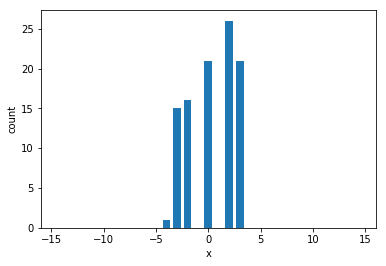

In [32]:
np.random.seed(13)
measure(7,5,100,lambda c,n,op: CT(c,range(5),10,0.1*2*n,op,[0.5,1]))

Initial = 0
    0.5 * |0>|0>
 + 0.5 * |0>|1>
 + 0.5 * |0>|2>
 + 0.5 * |0>|3>


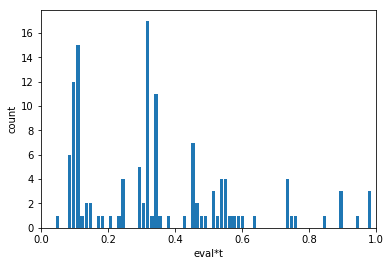

   (-0.00442703-0.0428969j)    * |0.319068>|0>
 + (0.480746-0.0982516j)       * |0.319068>|1>
 + (0.448286-0.0810961j)       * |0.319068>|2>
 + (0.196125-0.0241038j)       * |0.319068>|3>
 + (0.04025-0.00862589j)       * |0.319068>|4>
 + (0.0049762-0.00296868j)     * |0.319068>|5>
 + (-0.00126061-0.000181977j)  * |0.319068>|6>
 + (-0.000205871-0.000229461j) * |0.319068>|7>
 + (0.00358069+0.00574339j)    * |0.319068>|8>
 + (-0.00462364-0.012909j)     * |0.319068>|9>
 + (-0.0336217+0.0384826j)     * |0.319068>|10>
 + (0.0678967-0.0770904j)      * |0.319068>|11>
 + (0.0262637-0.032241j)       * |0.319068>|12>
 + (0.000387912-0.000915056j)  * |0.319068>|13>
 + (-0.00536639-0.00572052j)   * |0.319068>|14>
 + (0.0144686+0.0185291j)      * |0.319068>|15>
 + (0.00530157+0.00820305j)    * |0.319068>|-16>
 + (0.00139883+0.00694383j)    * |0.319068>|-15>
 + (-0.00424867-0.00749884j)   * |0.319068>|-14>
 + (-0.00469036-0.00741723j)   * |0.319068>|-13>
 + (-0.00341569-0.02476j)      * |0.319068>|-1

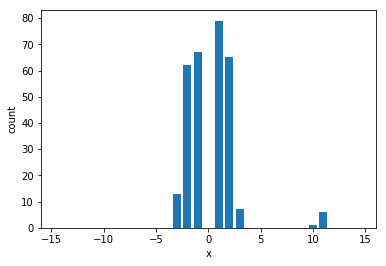

   (0.613292+0.157869j)       * |0.110447>|0>
 + (0.470934+0.117019j)       * |0.110447>|1>
 + (0.223008+0.0549725j)      * |0.110447>|2>
 + (0.0626037+0.0145096j)     * |0.110447>|3>
 + (0.0133578+0.000781663j)   * |0.110447>|4>
 + (-0.0013264-0.00166344j)   * |0.110447>|5>
 + (-0.00408883-0.0015394j)   * |0.110447>|6>
 + (-0.000339707-0.00312356j) * |0.110447>|7>
 + (0.00123145+0.0045393j)    * |0.110447>|8>
 + (0.00442089-0.00690485j)   * |0.110447>|9>
 + (-0.00152279+0.0163015j)   * |0.110447>|10>
 + (-0.0286621+0.0143635j)    * |0.110447>|11>
 + (-0.011407+0.00355741j)    * |0.110447>|12>
 + (-0.0022554-0.00162984j)   * |0.110447>|13>
 + (0.00117589-0.000273308j)  * |0.110447>|14>
 + (-0.000325015-0.0041085j)  * |0.110447>|15>
 + (0.000551089+0.0117662j)   * |0.110447>|-16>
 + (-0.00105586-0.00538767j)  * |0.110447>|-15>
 + (-0.00144808+0.00296899j)  * |0.110447>|-14>
 + (0.000983401-0.00137546j)  * |0.110447>|-13>
 + (0.00112045-0.00756124j)   * |0.110447>|-12>
 + (-0.00499207-0.

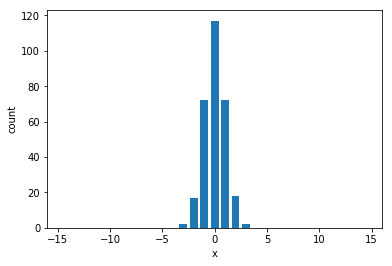

In [33]:
measure(9,5,300,lambda c,n,op: CT(c,range(5),10,0.1*2*n,op,[0.5,1]),prep=sqc.operator(14).H(0).H(1),x0=0,x1=1)